In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
from springstone.data import get_data, get_missing_dates, create_train_test, create_df_for_prophet
from springstone.utils import bollinger_bands, moving_average
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import plot_forecast_component_plotly
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [26]:
hist = get_data('AAPL')

[*********************100%***********************]  1 of 1 completed


In [27]:
hist

,Open,High,Low,Close,Volume
Date,,,,,
2012-02-21,18.102858,18.387501,18.004286,18.387501,605595200
2012-02-22,18.324286,18.410357,18.181070,18.322857,483302400
2012-02-23,18.395714,18.493929,18.196428,18.442499,568027600
2012-02-24,18.559643,18.674999,18.522858,18.657499,415072000
2012-02-27,18.618214,18.875000,18.438572,18.777143,547582000
...,...,...,...,...,...
2022-02-14,167.369995,169.580002,166.559998,168.880005,86185500
2022-02-15,170.970001,172.949997,170.250000,172.789993,64286300
2022-02-16,171.850006,173.339996,170.050003,172.550003,61177400


In [28]:
non_business_days = get_missing_dates(hist, True)
an_array = np.full((non_business_days.shape[0], 1), np.nan)
an_array.shape

(1133, 1)

In [29]:
concatenated = pd.concat([hist[['Close']], pd.DataFrame(an_array, index=non_business_days, columns=['Close'])])

In [30]:
concatenated = concatenated.sort_index()
concatenated.rename_axis(index='Date', inplace=True)

In [31]:
concatenated = concatenated.fillna(method='ffill')

In [32]:
concatenated

,Close
Date,
2012-02-21,18.387501
2012-02-22,18.322857
2012-02-23,18.442499
2012-02-24,18.657499
2012-02-25,18.657499
...,...
2022-02-14,168.880005
2022-02-15,172.789993
2022-02-16,172.550003


In [33]:
df_prophet = create_df_for_prophet(concatenated)
df_train, df_test = create_train_test(df_prophet)

In [34]:
df_train

,ds,y
0,2012-02-21,18.387501
1,2012-02-22,18.322857
2,2012-02-23,18.442499
3,2012-02-24,18.657499
4,2012-02-25,18.657499
...,...,...
2916,2020-02-15,81.237503
2917,2020-02-16,81.237503
2918,2020-02-17,81.237503
2919,2020-02-18,79.750000


In [35]:
df_test

,ds,y
2921,2020-02-20,80.074997
2922,2020-02-21,78.262497
2923,2020-02-22,78.262497
2924,2020-02-23,78.262497
2925,2020-02-24,74.544998
...,...,...
3646,2022-02-14,168.880005
3647,2022-02-15,172.789993
3648,2022-02-16,172.550003
3649,2022-02-17,168.880005


In [36]:
non_business_days_df = pd.DataFrame({'holiday': 'non business day',
                                  'ds': non_business_days})

In [37]:
non_business_days_df

,holiday,ds
0,non business day,2012-02-25
1,non business day,2012-02-26
2,non business day,2012-03-03
3,non business day,2012-03-04
4,non business day,2012-03-10
...,...,...
1128,non business day,2022-01-30
1129,non business day,2022-02-05
1130,non business day,2022-02-06
1131,non business day,2022-02-12


In [38]:
m_prophet = Prophet(holidays=non_business_days_df)
m_prophet.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -80.3622


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7267.21     0.0517129       1160.68       1.166      0.1166      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7303.37     0.0106924       456.687       2.431     0.02431      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7311.95     0.0102775       774.401           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7319.48    0.00887635       625.283      0.5338           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7322.74   0.000563668       90.4905           1           1      602   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     538     

In [39]:
n_days_prediction=90
future = m_prophet.make_future_dataframe(periods=n_days_prediction)
future

,ds
0,2012-02-21
1,2012-02-22
2,2012-02-23
3,2012-02-24
4,2012-02-25
...,...
3006,2020-05-15
3007,2020-05-16
3008,2020-05-17
3009,2020-05-18


In [40]:
forecast = m_prophet.predict(future)

In [41]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'non business day']]

,ds,yhat,yhat_lower,yhat_upper,non business day
0,2012-02-21,22.166714,17.830067,27.099082,0.00000
1,2012-02-22,22.120518,17.307435,27.109233,0.00000
2,2012-02-23,21.952642,16.868120,26.931929,0.00000
3,2012-02-24,21.787783,16.952354,26.755527,0.00000
4,2012-02-25,21.663230,16.827683,26.714263,0.10711
...,...,...,...,...,...
3006,2020-05-15,66.814896,61.888701,71.929697,0.00000
3007,2020-05-16,66.821338,61.764454,71.729697,0.10711
3008,2020-05-17,66.827534,61.879156,71.863466,0.10711
3009,2020-05-18,66.898824,61.793080,72.098899,0.00000


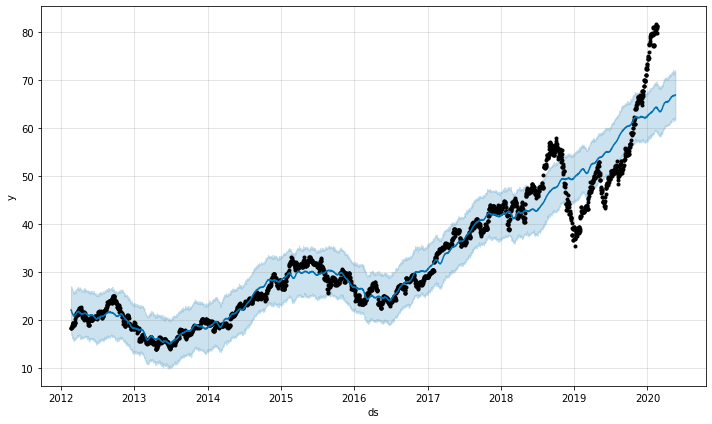

In [42]:
m_prophet.plot(forecast);

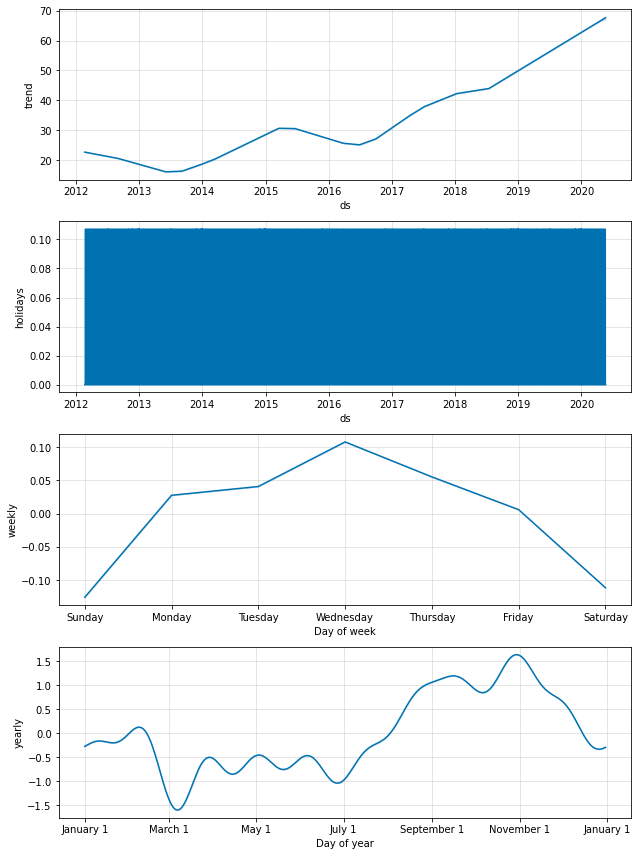

In [43]:
m_prophet.plot_components(forecast);

In [44]:
#plot_forecast_component_plotly(m_prophet, forecast, 'non business day')

In [45]:
forecast = forecast[- n_days_prediction:][['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'non business day']]

In [46]:
forecast

,ds,yhat,yhat_lower,yhat_upper,non business day
2921,2020-02-20,64.131829,59.244424,69.208772,0.00000
2922,2020-02-21,64.018845,58.810973,68.946806,0.00000
2923,2020-02-22,63.941309,59.120497,69.185246,0.10711
2924,2020-02-23,63.857610,58.647100,68.488833,0.10711
2925,2020-02-24,63.834257,58.921190,68.755258,0.00000
...,...,...,...,...,...
3006,2020-05-15,66.814896,61.888701,71.929697,0.00000
3007,2020-05-16,66.821338,61.764454,71.729697,0.10711
3008,2020-05-17,66.827534,61.879156,71.863466,0.10711
3009,2020-05-18,66.898824,61.793080,72.098899,0.00000


In [47]:
df_test[:n_days_prediction]

,ds,y
2921,2020-02-20,80.074997
2922,2020-02-21,78.262497
2923,2020-02-22,78.262497
2924,2020-02-23,78.262497
2925,2020-02-24,74.544998
...,...,...
3006,2020-05-15,76.927498
3007,2020-05-16,76.927498
3008,2020-05-17,76.927498
3009,2020-05-18,78.739998


In [48]:
mae_prophet = mean_absolute_error(df_test[:n_days_prediction]['y'], forecast['yhat'])
mape_prophet = mean_absolute_percentage_error(df_test[:n_days_prediction]['y'], forecast['yhat'])
print(f'MAE: {mae_prophet}')
print(f'MAPE: {mape_prophet}')

MAE: 6.2445443400981935
MAPE: 0.08754364219905872
